In [ ]:
cd ~/qdpy-numpyro

In [ ]:
%run vorontsov_qdpy/mode_lister.py --nmin 5 --nmax 5 --lmin 60 --lmax 64
%run vorontsov_qdpy/precompute_ritzlavely.py
%run vorontsov_qdpy/generate_synthetic_eigvals.py --load_mults 1 --knot_num 5 --rth 0.97

In [ ]:
%run vorontsov_qdpy/save_reduced_problem.py
%run vorontsov_qdpy/save_reduced_problem_M.py

In [ ]:
%run vorontsov_qdpy/run_reduced_problem_model.py --warmup 10 --chain_num 5 --maxiter 10

In [ ]:
np.random.rand(5) @ (zfull[0][:, :, 0] @ np.random.rand(5))

In [ ]:
zfull = param_coeff @ true_params + fixed_part
zM = param_coeff_M @ true_params + fixed_part_M
bkm = param_coeff_bkm @ true_params + fixed_part_bkm
clp = get_clp(bkm)

mode_idx = -1
clp_200 = clp[mode_idx]

zfull_200 = zfull[mode_idx]
zM_200 = zM[mode_idx]
bkm_200 = bkm[mode_idx]
zfull_200_flat = jnp.reshape(zfull_200, (max_nbs*max_nbs*len_mmax), order='F')
zM_200_flat = jnp.reshape(zM_200, (max_nbs*max_nbs*len_mmax), order='F')
bkm_200_flat = jnp.reshape(bkm_200, (max_nbs*max_nbs*len_mmax), order='F')

sparse_idx_200 = sparse_idx[mode_idx]
sparseM_idx_200 = sparse_idx_M[mode_idx]

sparse_200_flat = jnp.reshape(sparse_idx_200, (max_nbs*max_nbs*len_mmax, 2), order='F')
sparseM_200_flat = jnp.reshape(sparseM_idx_200, (max_nbs*max_nbs*len_mmax, 2), order='F')


zf_dense = sparse.BCOO((zfull_200_flat, sparse_200_flat), shape=(dim_hyper, dim_hyper)).todense()
zMf_dense = sparse.BCOO((zM_200_flat, sparseM_200_flat), shape=(dim_hyper, dim_hyper)).todense()
bkm_dense = sparse.BCOO((bkm_200_flat, sparse_200_flat), shape=(dim_hyper, dim_hyper)).todense()
zf_diag = np.diag(zf_dense)
zMf_diag = np.diag(zMf_dense)

ev_200_V11 = np.sum(clp_200.conj() * (zM_200 * clp_200[:, NAX, :]).sum(axis=0), axis=0)

supmat = np.load("supmat_qdpt_200.npy").real
ev_200_eigh, evec_200 = jnp.linalg.eigh(supmat)
ev_200_eigh = eigval_sort_slice(ev_200_eigh/2./omega0_arr[-1], evec_200)[:401]

lmax_pjl = int(len_mmax//2)
dell = lmax_pjl - 200
ac1 = Pjl[-1] @ ev_200_V11/Pjl_norm[-1]
ac2 = Pjl[-1][:, dell:-dell] @ ev_200_eigh/Pjl_norm[-1]
print(ac1*GVARS.OM*1e6)
print(ac2*GVARS.OM*1e6)

In [ ]:
abs(ev_200_V11[dell:-dell] - ev_200_eigh).max()*1000/200

In [ ]:
def plot_fullmat(mat):
    vmax = abs(mat).max()
    fig = plt.figure()
    plt.imshow(mat, cmap='seismic', vmax=vmax/100000, vmin=-vmax/100000)
    return fig

fig = plot_fullmat(zMf_dense)
fig.show()

In [ ]:
plt.figure()
for i in range(5):
    plt.semilogy(abs(clp[0, 4, :]), label=i)
plt.legend()
plt.show()

### Comparing supermatrices with the ones constructed using qdPy

In [ ]:
supmat = np.load("supmat_qdpt_200.npy").real
matsize = supmat.shape[0]
qdpt_diag = np.diag(supmat)
plt.figure()
plt.plot(zf_diag[:matsize])
plt.plot(qdpt_diag, '--r')
plt.show()

plt.figure()
plt.semilogy(abs(zf_diag[:matsize] - qdpt_diag))
plt.show()

plt.figure()
plt.semilogy(abs(zf_dense[:matsize, :matsize].flatten() - supmat.flatten()))
plt.show()

matdiff = abs(supmat - zf_dense[:matsize, :matsize])
thresh = 1e-11
print(f"max diff = {matdiff.max()}")
print(f"count of diff > {thresh} = {(matdiff>thresh).sum()}")

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs = axs.flatten()
im1 = axs[0].imshow(zf_dense[:matsize, :matsize])
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(supmat)
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(zf_dense[:matsize, :matsize] - supmat)
plt.colorbar(im2, ax=axs[2])
fig.show()



## Testing out the compare_model function

In [ ]:
mult_idx = -1
z0 = param_coeff_M[mult_idx] @ true_params + fixed_part_M[mult_idx]
zfull = param_coeff[mult_idx] @ true_params + fixed_part[mult_idx]
bkm = param_coeff_bkm @ true_params + fixed_part_bkm

for midx in range(nmults):
    bkm = jidx_update(bkm, 
                      jidx[midx, :, :, :],
                      -1.0*bkm[midx]/dom_dell_jax[midx])
                         
clp = get_clp(bkm)[mult_idx]
bkm = bkm[mult_idx]
                        
omegaref = omega0_arr_jax[mult_idx]
ell0 = ell0_arr_jax[mult_idx]

z1 = zfull/2./omegaref - z0
_eigval0mult = get_eig_corr(clp, z0)*GVARS.OM*1e6
_eigval1mult = get_eig_corr(clp, z1)*GVARS.OM*1e6
_eigval_mult = _eigval0mult + _eigval1mult

Pjl_local = Pjl[mult_idx]

In [ ]:
plt.figure()
plt.plot(_eigval_mult[-10:], '--r')
plt.plot(Pjl_local[0, -10:], 'k')
plt.show()

plt.figure()
plt.plot(_eigval_mult[:10], '--r')
plt.plot(Pjl_local[0, :10], 'k')
plt.show()

### Explicit computation of eigenvalues

In [ ]:
def eigval_sort_slice(eigval, eigvec):
    eigbasis_sort = np.zeros(len(eigval), dtype=int)
    for i in range(len(eigval)):
        eigbasis_sort[i] = np.argmax(abs(eigvec[i]))
    return eigval[eigbasis_sort]

ell0 = 200
omegaref = omega0_arr[-1]
supmat = np.load(f"supmat_qdpt_{ell0}.npy").real


eigvals, eigvecs = np.linalg.eigh(supmat)
eigvals = eigval_sort_slice(eigvals, eigvecs)
eigvals = eigvals[:2*ell0+1]/2./omegaref*GVARS.OM*1e6

supmat2 = zf_dense[:matsize, :matsize]
eigvals2, eigvecs2 = np.linalg.eigh(supmat2)
eigvals2 = eigval_sort_slice(eigvals2, eigvecs2)
eigvals2 = eigvals2[:2*ell0+1]/2./omegaref*GVARS.OM*1e6

acoeffs = (Pjl[-1][:, :2*ell0+1] @ eigvals)/Pjl_norm[-1]
acoeffs2 = (Pjl[-1][:, :2*ell0+1] @ eigvals2)/Pjl_norm[-1]
print(acoeffs)
print(acoeffs2)

## TESTING OUT DPY_JAX

In [9]:
cd ~/qdpy-numpyro

/mnt/disk2/samarth/qdpy-numpyro


MODE NOT FOUND : l =  10, n =  0
MODE NOT FOUND : l =  11, n =  0
MODE NOT FOUND : l =  12, n =  0
MODE NOT FOUND : l =  13, n =  0
MODE NOT FOUND : l =  14, n =  0
MODE NOT FOUND : l =  15, n =  0
MODE NOT FOUND : l =  16, n =  0
MODE NOT FOUND : l =  17, n =  0
MODE NOT FOUND : l =  18, n =  0
MODE NOT FOUND : l =  19, n =  0
MODE NOT FOUND : l =  20, n =  0
MODE NOT FOUND : l =  21, n =  0
MODE NOT FOUND : l =  22, n =  0
MODE NOT FOUND : l =  23, n =  0
MODE NOT FOUND : l =  24, n =  0
MODE NOT FOUND : l =  25, n =  0
MODE NOT FOUND : l =  26, n =  0
MODE NOT FOUND : l =  27, n =  0
MODE NOT FOUND : l =  28, n =  0
MODE NOT FOUND : l =  29, n =  0
MODE NOT FOUND : l =  30, n =  0
MODE NOT FOUND : l =  31, n =  0
MODE NOT FOUND : l =  32, n =  0
MODE NOT FOUND : l =  33, n =  0
MODE NOT FOUND : l =  34, n =  0
MODE NOT FOUND : l =  35, n =  0
MODE NOT FOUND : l =  36, n =  0
MODE NOT FOUND : l =  37, n =  0
MODE NOT FOUND : l =  38, n =  0
MODE NOT FOUND : l =  39, n =  0
MODE NOT F

Precomputing for s=5: 100%|██████████| 1915/1915 [01:29<00:00, 21.36it/s]


JAX using: cpu


Loading eigenfunctions...: 100%|██████████| 1915/1915 [00:25<00:00, 74.83it/s]


JAX using: cpu


Precomputing for s=5: 100%|██████████| 1915/1915 [01:24<00:00, 22.57it/s]


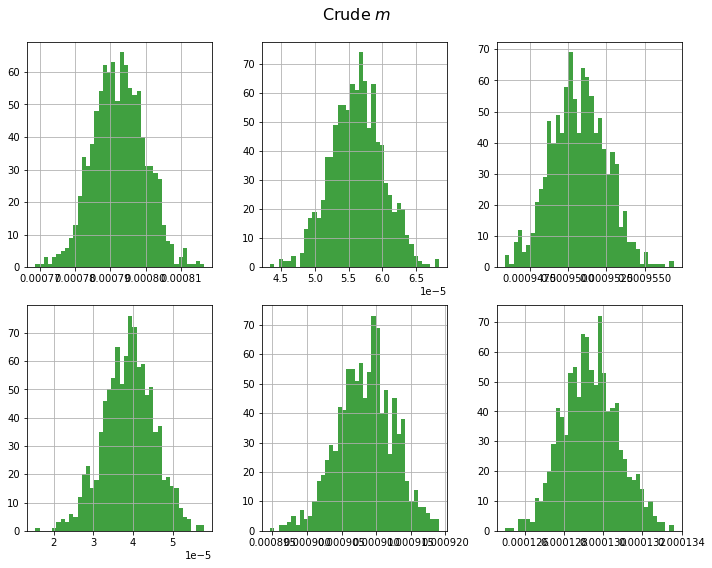

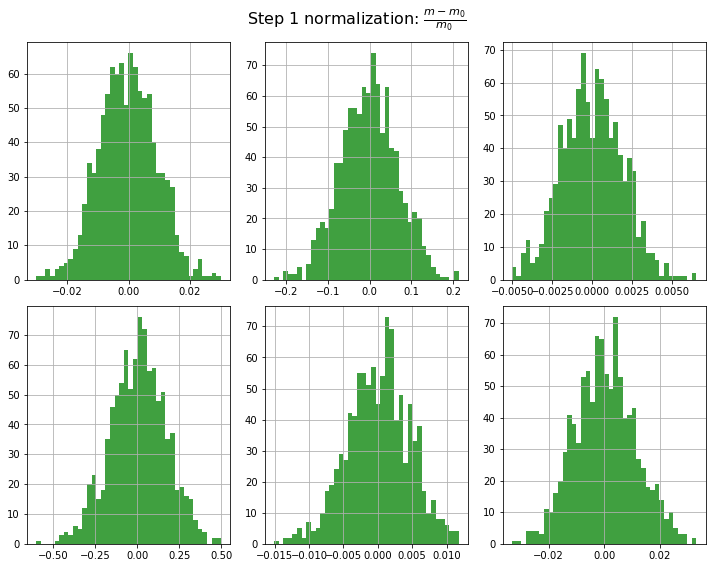

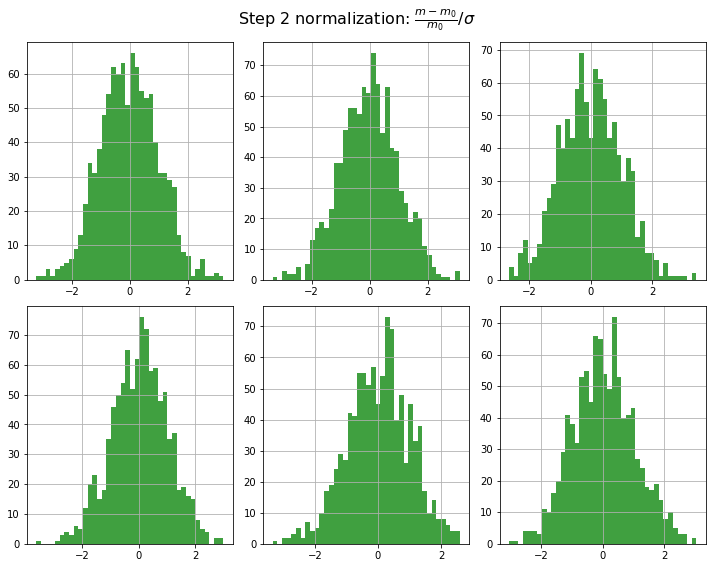

In [10]:
%run dpy_jax/mode_lister.py --nmin 0 --nmax 30 --lmin 10 --lmax 295
%run dpy_jax/precompute_ritzlavely.py
%run dpy_jax/generate_synthetic_eigvals.py --load_mults 1 --knot_num 15 --rth 0.8
%run dpy_jax/save_reduced_problem.py

In [ ]:
%run dpy_jax/save_reduced_problem.py

In [ ]:
sind_arr

In [ ]:
%run dpy_jax/run_reduced_problem_model.py --warmup 10 --chain_num 5 --maxiter 10

In [11]:
%run dpy_jax/run_reduced_problem_newton.py --mu 10.

data_acoeffs = [ 0.43637642  0.02201884 -0.00439328  0.43609714  0.02192269 -0.00446107
  0.43623706  0.02188044 -0.00441448  0.43620886  0.02177563 -0.00427198
  0.43631978  0.02218617 -0.0044009 ]


[  1 |  204.9 sec ] data_misfit =  5.68382e+03 loss-diff =  1.00000e+25; max-grads =  1.35458e+04 model_misfit= 6.56714e-02


[  2 |  183.9 sec ] data_misfit =  5.68382e+03 loss-diff =  1.90994e-11; max-grads =  1.16823e-10 model_misfit= 6.56714e-02
Total time taken =      388.801 seconds
[0.99913329 1.05541177 0.998266   1.03536383 0.99674862 1.04254436
 0.99594053 1.04661204 0.99591245 1.04287071 0.99685964 1.02859079
 0.99862349 1.01630746 0.99999113 1.01167696 1.00095457 1.01203289
 1.00040342 1.01168338 1.00040792 1.0055867 ]


In [1]:
mulist = np.logspace(-4, 3, 50)

In [2]:
mulist

array([1.00000000e-04, 1.38949549e-04, 1.93069773e-04, 2.68269580e-04,
       3.72759372e-04, 5.17947468e-04, 7.19685673e-04, 1.00000000e-03,
       1.38949549e-03, 1.93069773e-03, 2.68269580e-03, 3.72759372e-03,
       5.17947468e-03, 7.19685673e-03, 1.00000000e-02, 1.38949549e-02,
       1.93069773e-02, 2.68269580e-02, 3.72759372e-02, 5.17947468e-02,
       7.19685673e-02, 1.00000000e-01, 1.38949549e-01, 1.93069773e-01,
       2.68269580e-01, 3.72759372e-01, 5.17947468e-01, 7.19685673e-01,
       1.00000000e+00, 1.38949549e+00, 1.93069773e+00, 2.68269580e+00,
       3.72759372e+00, 5.17947468e+00, 7.19685673e+00, 1.00000000e+01,
       1.38949549e+01, 1.93069773e+01, 2.68269580e+01, 3.72759372e+01,
       5.17947468e+01, 7.19685673e+01, 1.00000000e+02, 1.38949549e+02,
       1.93069773e+02, 2.68269580e+02, 3.72759372e+02, 5.17947468e+02,
       7.19685673e+02, 1.00000000e+03])

In [ ]:
grads

In [ ]:
c_arr_true = np.ones_like(c_arr_fit)
bsp_basis = np.load('bsp_basis.npy')

def get_wsr(carr, s=3):
    carr_full = np.zeros_like(c_arr_fit)
    if s==3:
        carr_full[::2] = carr[::2] * true_params_flat[0::2]
    else:
        carr_full[1::2] = carr[1::2] * true_params_flat[1::2]
    return carr_full @ bsp_basis


def get_wsr2(carr):
    carr_full = np.zeros_like(c_arr_fit)
    carr_full[::2] = carr[::2] * true_params_flat[0::2]
    carr_full[1::2] = carr[1::2] * true_params_flat[1::2]
    return carr_full @ bsp_basis


def D2(f, x):
    df_dx = np.gradient(f, x, edge_order=2)
    df2_dx2 = np.gradient(df_dx, x, edge_order=2)
    return df2_dx2

def get_smoothness(f, r):
    d2f_dr2 = D2(f, r)
    return np.trapz(d2f_dr2**2, r)

c_arr_true = np.ones_like(c_arr_fit)
w3t = get_wsr(c_arr_true, 3)
w5t = get_wsr(c_arr_true, 5)

w3f = get_wsr(c_arr_fit, 3)
w5f = get_wsr(c_arr_fit, 5)

w3t_smooth = get_smoothness(w3t, GVARS.r)
w5t_smooth = get_smoothness(w5t, GVARS.r)
w3f_smooth = get_smoothness(w3f, GVARS.r)
w5f_smooth = get_smoothness(w5f, GVARS.r)

#print(f"{w3t_smooth:.5e}, {w3f_smooth:.5e}")
#print(f"{w5t_smooth:.5e}, {w5f_smooth:.5e}\n")

c_arr_ren = jf.model_renorm(c_init*true_params_flat, true_params_flat, sigma2scale)
jf.model_denorm(c_arr_ren, true_params_flat, sigma2scale)/true_params_flat

c_arr_fit_ren = jf.model_renorm(c_arr_fit*true_params_flat, true_params_flat, sigma2scale)
print(f"{(w3t_smooth + w5t_smooth):.5e}, {(w3f_smooth+w5f_smooth):.5e}")
print(f"{model_misfit_fn(c_arr_ren):.5e}, {model_misfit_fn(c_arr_fit_ren):.5e}")

In [ ]:
c_arr_fit

In [ ]:
norm = abs(w3f).max()/abs(w5f).max()

plt.figure()
plt.plot(GVARS.r, w3f, 'b')
plt.plot(GVARS.r, -w5f*norm, '--k')
plt.show()

In [ ]:
norm

In [ ]:
D_bsp_j_D_bsp_k[0::2, 0::2] - D_bsp_j_D_bsp_k[1::2, 1::2]

In [ ]:
c_arr_true = np.ones_like(c_arr_fit)
wt = get_wsr2(c_arr_true)
wf = get_wsr2(c_arr_fit)

wt_smooth = get_smoothness(wt, GVARS.r)
wf_smooth = get_smoothness(wf, GVARS.r)

c_arr_ren = jf.model_renorm(c_init*true_params_flat, true_params_flat, sigma2scale)
jf.model_denorm(c_arr_ren, true_params_flat, sigma2scale)/true_params_flat

c_arr_fit_ren = jf.model_renorm(c_arr_fit*true_params_flat, true_params_flat, sigma2scale)
print(f"{(wt_smooth):.5e}, {(wf_smooth):.5e}")
print(f"{model_misfit_fn(c_arr_ren):.5e}, {model_misfit_fn(c_arr_fit_ren):.5e}")